In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

plt.ion() 
import timm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
all_vit_models = timm.list_models('*vit*', pretrained=True)
all_vit_models

['vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_deit_base_distilled_patch16_224',
 'vit_deit_base_distilled_patch16_384',
 'vit_deit_base_patch16_224',
 'vit_deit_base_patch16_384',
 'vit_deit_small_distilled_patch16_224',
 'vit_deit_small_patch16_224',
 'vit_deit_tiny_distilled_patch16_224',
 'vit_deit_tiny_patch16_224',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_small_patch16_224']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
!mkdir /content/gdrive/MyDrive/Kaggle/CoronaHack
%cd /content/gdrive/MyDrive/Kaggle/CoronaHack

!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip \*.zip  && rm *.zip

## Loading Labels for the Dataset

In [ ]:
metadata_path = "/content/gdrive/MyDrive/Kaggle/CoronaHack/Chest_xray_Corona_Metadata.csv"
metadata = pd.read_csv(metadata_path, index_col=0)

normal_meta = metadata[metadata["Label"] == "Normal"]
virus_meta = metadata[metadata["Label_1_Virus_category"] == "Virus"]

In [ ]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
!mkdir $data_dir
normal_dir = f"{data_dir}/normal"
virus_dir = f"{data_dir}/virus"
dir_dict = {
    normal_dir: normal_meta, 
    virus_dir: virus_meta,
}
for dir in dir_dict.keys():
  if not os.path.exists(dir):
    os.mkdir(dir)
old_data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"

for dir, meta in dir_dict.items():
  for im in meta["X_ray_image_name"]:
    if os.path.exists(f"{old_data_dir}/train/{im}"):
      os.rename(f"{old_data_dir}/train/{im}", f"{dir}/{im}")
    elif os.path.exists(f"{old_data_dir}/test/{im}"):
      os.rename(f"{old_data_dir}/test/{im}", f"{dir}/{im}")

In [6]:
input_size = 3, 128, 128
img_size = 128
num_classes = 2
batch_size = 32

interpolation = 'bicubic'
IMAGENET_DEFAULT_MEAN  = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
DEFAULT_CROP_PCT = 0.9

## Create Dataset and Dataloader

In [ ]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
from timm.data import create_dataset, create_loader
# create the train and eval datasets
train_dataset = create_dataset(name='', root=data_dir, split='train', is_training=True,
        batch_size=batch_size)
val_dataset = create_dataset(name='', root=data_dir, split='validation', 
                              is_training=False, batch_size=batch_size)
train_len, val_len = len(train_dataset), len(val_dataset)

# create data loaders 
loader_train = create_loader(
        train_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=True,
        scale=[0.08, 1.0],
        ratio=[3./4., 4./3.],
        interpolation=interpolation,
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD,
        num_workers=2)

loader_val = create_loader(
        val_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=False,
        interpolation=interpolation,
        mean=IMAGENET_DEFAULT_MEAN,
        std=IMAGENET_DEFAULT_STD,
        crop_pct=DEFAULT_CROP_PCT)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(loader_train))

out = tv.utils.make_grid(inputs)

imshow(out)


## Fine-Tuning

In [13]:
def eval_corona(model, loader_val):
  model.eval()

  preds = []
  with torch.no_grad():
    for x, t in loader_val:
      x, t = x.to(device), t.to(device) # comment this line if use option1 dataloader
      logits = model(x)
      preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

  return sum(preds) / val_len

In [ ]:
# ViT-B/16
# model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=num_classes, img_size=img_size)
# R50+ViT-B/16
model = timm.create_model('vit_base_resnet50_224_in21k', pretrained=True, num_classes=num_classes, img_size=img_size)
model.to(device)

#### Optimizer Config

In [15]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

optimizer = optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

#### Loss Function

In [16]:
from timm.loss import LabelSmoothingCrossEntropy
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.1).cuda()

#### Learning Rate Scheduler

In [17]:
from timm.scheduler import StepLRScheduler
num_epochs = 10
noise_range = None
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

## Train Vision Transformer and Evaluate on Validation Dataset

In [ ]:
iters = 10

pb_train = display(progress(0, iters), display_id=True)
losses = [[]]
accus_train = [[]]
accus_val = []

for i in range(iters):
  for x, t in loader_train:
    logits = model(x)
    loss = loss_fn(logits, t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].append(torch.sum(torch.max(logits, dim=1)[1] == t))
    # break

  losses[-1] = sum(losses[-1])
  losses.append([])
  accus_train[-1] = sum(accus_train[-1]) / train_len
  accus_train.append([])

  # step LR for next epoch
  lr_scheduler.step(i + 1)

  accus_val.append(eval_corona(model, loader_val))
  model.train()

  pb_train.update(progress(i, iters))
  print(f'\r[Step {i+1}] loss={loss:.2e} '
        f'\r[Step {i+1}] loss={losses[-2]:.2e} '
        f'train accu={accus_train[-2]:.2%} '
        f'validation accu={accus_val[-1]:.2%} '
        # , end=''
        , flush=True)
  # break

[Step 1] loss=4.50e+01 train accu=63.84% validation accu=75.69% 
[Step 2] loss=2.89e+01 train accu=86.96% validation accu=88.91% 
[Step 3] loss=2.76e+01 train accu=86.91% validation accu=85.29% 
[Step 4] loss=2.65e+01 train accu=88.60% validation accu=90.19% 
[Step 5] loss=2.49e+01 train accu=90.61% validation accu=90.19% 
[Step 6] loss=2.47e+01 train accu=89.83% validation accu=89.98% 
[Step 7] loss=2.36e+01 train accu=91.24% validation accu=91.68% 
[Step 8] loss=2.29e+01 train accu=92.16% validation accu=90.83% 
[Step 9] loss=2.32e+01 train accu=91.70% validation accu=90.62% 
[Step 10] loss=2.20e+01 train accu=92.75% validation accu=87.21% 


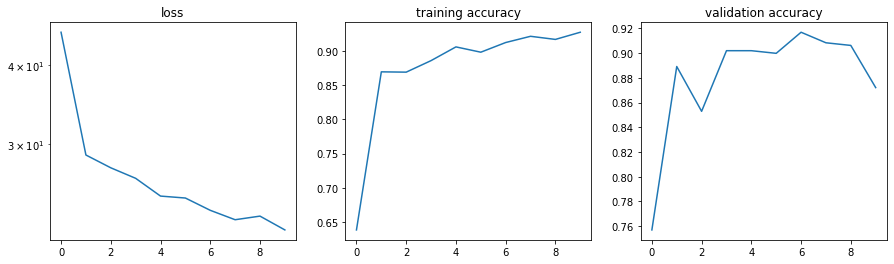

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train[:-1])
ax2.set_title('training accuracy')
ax3.plot(accus_val)
ax3.set_title('validation accuracy');

### Test Accuracy

In [18]:
data_dir = "/content/gdrive/MyDrive/Kaggle/CoronaHack/data1"
data_transforms = transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ])

image_datasets = datasets.ImageFolder(data_dir, data_transforms)
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

val_size = int(dataset_sizes*0.15)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [dataset_sizes-2*val_size, val_size, val_size], generator=torch.Generator().manual_seed(42))

model.eval()

loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False)
preds = []
with torch.no_grad():
  for x, t in loader_test:
    x, t = x.to(device), t.to(device) 
    logits = model(x)
    preds.append(torch.sum(torch.max(logits, dim=1)[1] == t))

accus_test = sum(preds) / len(test_dataset)
print(accus_test)

tensor(0.8785, device='cuda:0')
